In [21]:
import sys
sys.path.append('..')
from src.api import API
from src.dataloader import DataLoader
from src.prompter import prompter_factory
from src.scorer import scorer_factory, compare_models_bootstrap
from dotenv import load_dotenv
load_dotenv()
import os
import random

In [2]:
TOGETHER_API_KEY = os.getenv("API_KEY")
BASE_URL = "https://api.together.xyz"
ALLOWED_SYMPTOMS = ['anxiety', 'concentration problems', 'constipation', 'cough',
                    'diarrhea', 'fatigue', 'fever', 'headache', 'nausea', 
                    'numbness and tingling', 'pain', 'poor appetite', 'rash', 
                    'shortness of breath', 'trouble drinking fluids', 'vomiting', 'other']

## API

Using the API class provides a modular approach to client definition.

In [3]:
api = API(api_key=TOGETHER_API_KEY, base_url=BASE_URL)
client = api.get_openai()

## Data Loader

The DataLoader class loads the csv files. It verifies their existence and provides testing tools.

DataLoader allows for dataframe creation, with uniformization of the labels and column formatting.

We can use its method list_csv_files() to ensure that all our csv files were properly fetched by our pipeline.

In [4]:
dataloader = DataLoader(path="../data/")
print(dataloader.list_csv_files())

['../data/batch_1_gs.csv', '../data/batch_2_gs.csv', '../data/batch_3_gs.csv', '../data/batch_4_gs.csv', '../data/batch_5_gs.csv', '../data/batch_6_gs.csv', '../data/batch_7_gs.csv', '../data/batch_8_gs.csv', '../data/batch_9_gs.csv', '../data/batch_10_gs.csv']


With get_standardized_dataframe(), you can obtain a standardized dataframe that will be easier to handle during downstream specific tasks. Sanity checks are run in the background to ensure that your data follows the intended behavior.

In [5]:
df = dataloader.get_standardized_dataframe(context_col="Text Data",
                                           target_binary_col="symptom_status_gs",
                                           target_multilabel_col="symptom_detail_gs",
                                           keep_other_cols=True)

If you want to verify that the symptoms in your dataframe match a list of symptoms, you can use the following method:

In [6]:
dataloader.check_symptoms_validity(allowed_symptoms=ALLOWED_SYMPTOMS,
                                   symptoms_col="symptom_detail_gs")

Symptoms in dataframe are valid.


In [28]:
df.head()

,Context,Symptom Status_bd,Detailed Choices_bd,Source_x,Symptom Status_CVD,Detailed Choices_CVD,Source_y,Differences,Adjudication Decision,Pres_Abs_Diffs,...,Target headache,Target nausea,Target numbness and tingling,Target pain,Target poor appetite,Target rash,Target shortness of breath,Target trouble drinking fluids,Target vomiting,Target other
0,"D: How may I help you?\n\nP: Hi, umm, so I've ...",Positive,Fever;Other,RES0181.txt,Positive,Fever;Pain;Other,RES0181.txt,Pain,fever;other;trouble drinking fluids,NaN,...,False,False,False,False,False,False,False,True,False,True
1,D: OK. And how about your appetite? Has that c...,Positive,Fever;Poor appetite;Other,RES0181.txt,Positive,Fever;Pain;Poor appetite;Other,RES0181.txt,Pain,fever;other;poor appetite,NaN,...,False,False,False,False,True,False,False,False,False,True
2,D: OK. Have you had any any headaches?\n\nP: U...,Positive,Cough;Headache;Nausea;Pain;Shortness of breath...,RES0181.txt,Positive,Cough;Headache;Nausea;Pain;Shortness of breath...,RES0181.txt,NaN,NaN,NaN,...,True,True,False,True,False,False,True,False,True,True
3,D: Have you had any abdominal pain?\n\nP: No. ...,Positive,Constipation;Diarrhea;Fatigue;Pain;Rash;Other,RES0181.txt,Positive,Constipation;Diarrhea;Fatigue;Pain;Rash;Other,RES0181.txt,NaN,NaN,NaN,...,False,False,False,True,False,True,False,False,False,True
4,"P: I use an insulin pump, yeah.\n\nD: OK, exce...",Positive,Anxiety;Other,RES0181.txt,Positive,Anxiety,RES0181.txt,Other,anxiety,NaN,...,False,False,False,False,False,False,False,False,False,False


## Prompter

We can use the prompter factory function to generate the appropriate prompter class for our task. The returned class contains various useful methods for inference.

All the model and task specific logic is implemented in the backend!

In [8]:
Mixtral8x7B = prompter_factory(prompter_type="binary", # "binary" or "multilabel"
                               client=client,
                               model="mistralai/Mixtral-8x7B-Instruct-v0.1")

With the generate_single() method, you can check the output of your model on a simple prompt and context. It's useful to get a sense of how your model reacts to a prompt format.

The outputs are structured as following: *({finding: bool, model output: str (None if using function calling)}, number of tokens used)*

In [9]:
prompt = "Are any medical symptoms mentioned in the transcript"
context = "i have a headache every time i see a cat and i hear voices that are not there"
print(Mixtral8x7B.generate_single(prompt=prompt, context=context))

({'status': True, 'output': None}, 195)


Now that we confirmed the behavior of our model, we can easily generate the outputs for the entire dataset. The generate() method implements this in a parallelized fashion, with a progress bar. In the progress bar description, you can see the number of tokens that were used to generate the outputs.

In [12]:
# This operation is parallelized - the progress bar is not linear.
results = Mixtral8x7B.generate(df=df, prompt=prompt)

binary task using: mistralai/Mixtral-8x7B-Instruct-v0.1 - Total tokens: 200,340: 100%|██████████| 550/550 [00:39<00:00, 13.82it/s]


## Scorer

The scorer factory function returns the appropriate scorer for our task (binary or multi-label). It provides useful functions for assessing the performance of our model.

In [14]:
scorer = scorer_factory(scorer_type="binary", # "binary" or "multilabel"
                        data=df,
                        results=results,
                        model_name= "Mixtral 8x7B") # used for legends in plots

With the display_bootstrap_results method, we can use bootstrapping to assess various metrics. The user can choose the output format they want.

Bootstrapping Mixtral 8x7B: 100%|██████████| 1000/1000 [00:04<00:00, 245.60it/s]


accuracy: 0.6371 (0.6-0.6782 95% CI)
precision: 0.7458 (0.7024-0.7838 95% CI)
recall: 0.7214 (0.6787-0.7678 95% CI)
f1: 0.7331 (0.6993-0.768 95% CI)
Unstructured output ratio: 0.0 (0.0-0.0 95% CI)


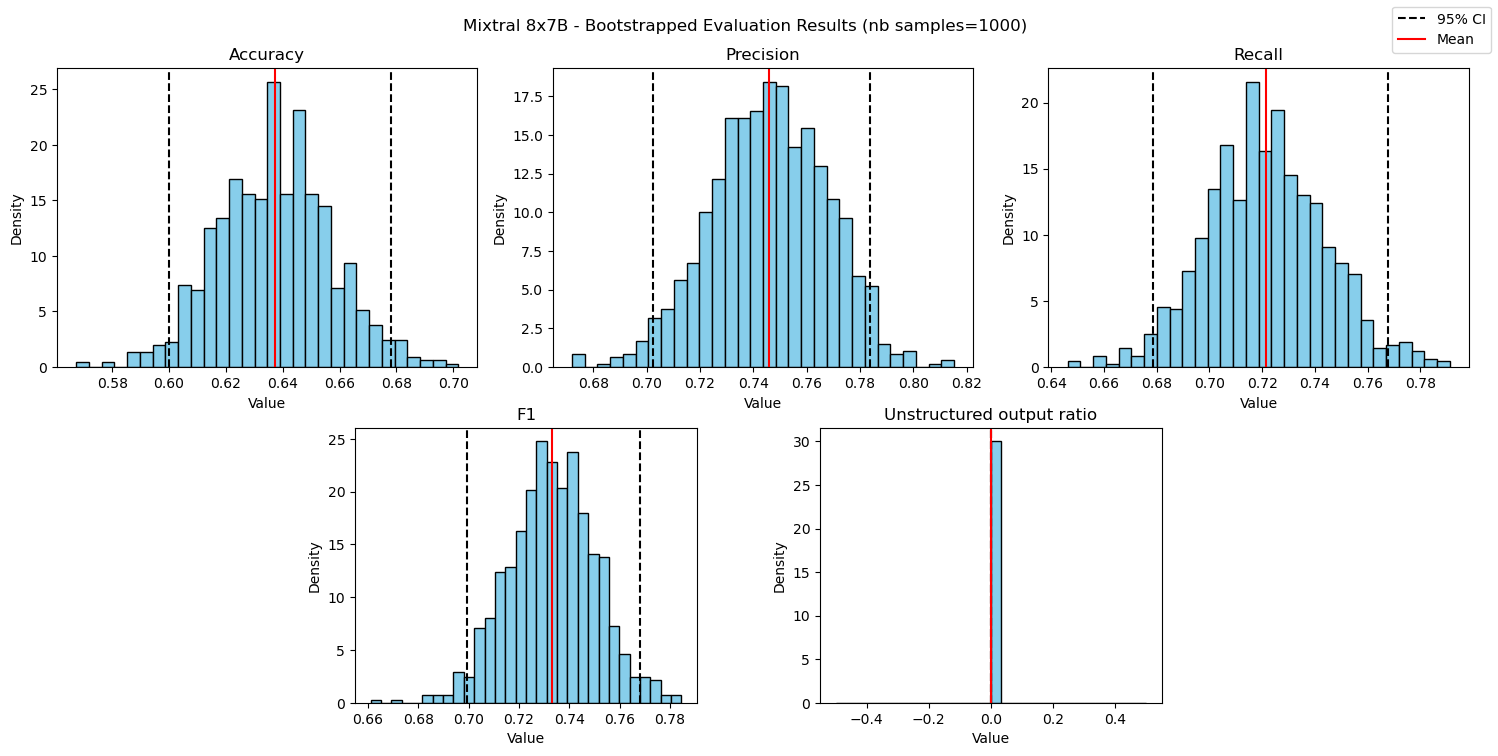

In [15]:
scorer.display_bootstrap_results(sample_size=len(df),
                                 output_type="both", # can be "text", "plot" or "both"
                                 n_samples=1000)

We can also use scorer objects to compare models. In this example, we introduce a new model to compare against the one we just implemented.

binary task using: mistralai/Mistral-7B-Instruct-v0.1 - Total tokens: 199,852: 100%|██████████| 550/550 [00:54<00:00, 10.07it/s]
Bootstrapping Mixtral 8x7B: 100%|██████████| 1000/1000 [00:03<00:00, 262.22it/s]


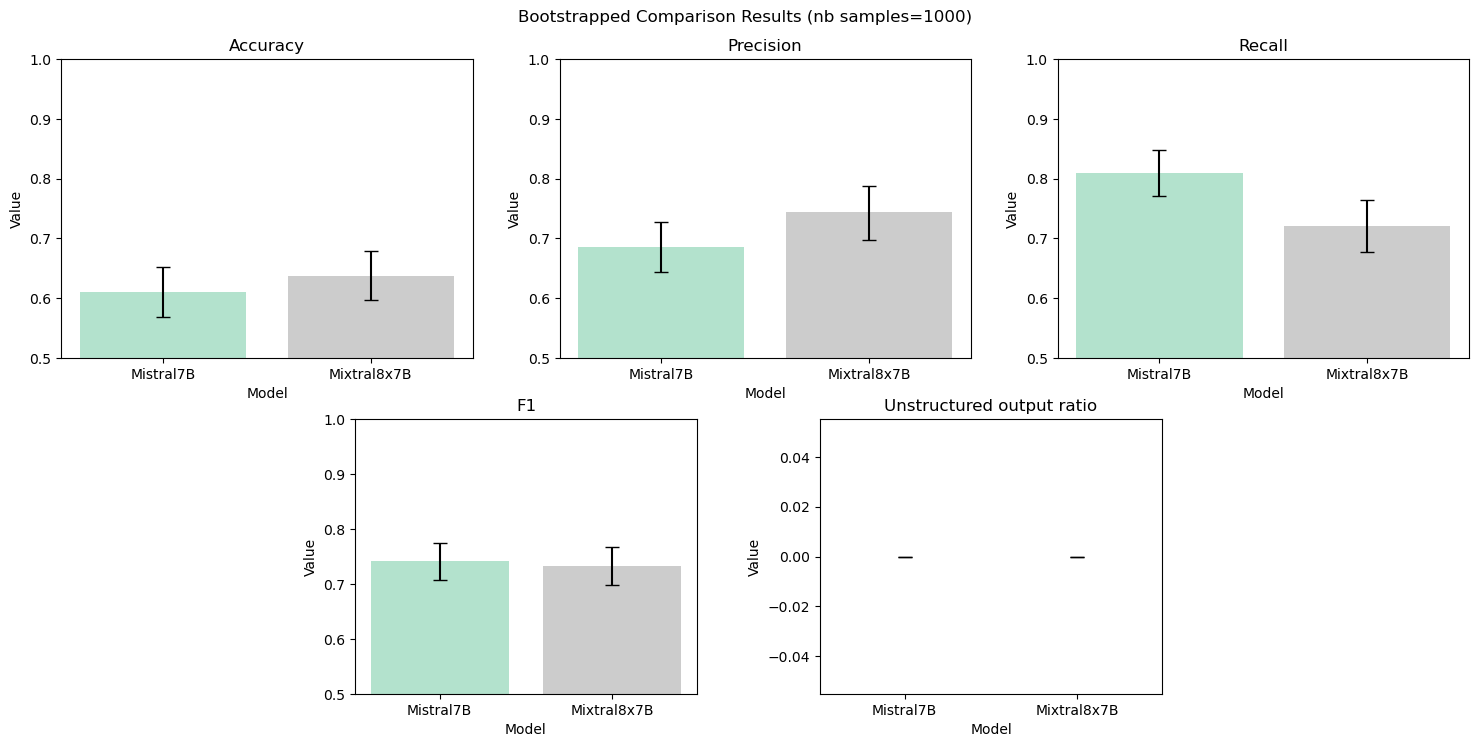

In [17]:
Mistral7B = prompter_factory(prompter_type="binary",
                             client=client,
                             model="mistralai/Mistral-7B-Instruct-v0.1")
results_mistral7b = Mistral7B.generate(df=df, prompt=prompt)
scorer_mistral7b = scorer_factory(scorer_type="binary", data=df, results=results_mistral7b, model_name="Mistral 7B")
dict_scorers = {"Mistral7B": scorer_mistral7b, "Mixtral8x7B": scorer}
compare_models_bootstrap(dict_scorers=dict_scorers, sample_size=len(df), n_samples=1000)

## Error Interrogation

If we want to plot the distribution of contexts for correct and incorrect predictions, we can use the following method from the scorer class. This method will also plot unstructured outputs as an additional category if there are any.

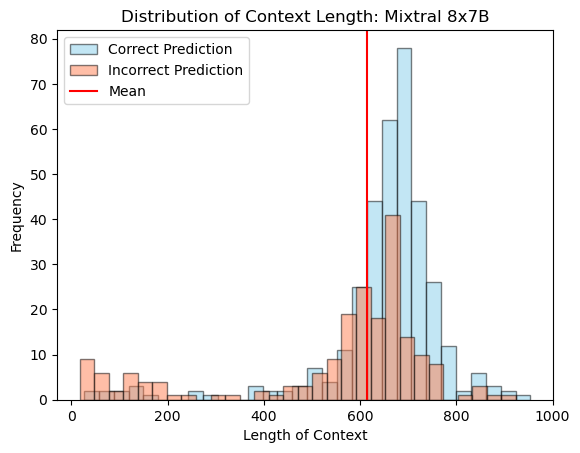

In [27]:
scorer.display_length_distribution()

If we want to investigate the errors produced by our model, the get_error_dataframe() method from the scorer class returns a dataframe containing all the rows that have errors.

In [18]:
df_error = scorer.get_error_dataframe()

For example, we could use this to plot random results from our model.

In [20]:
df_error.loc[:, "Concatenated"] = df_error.apply(
    lambda row: f"index: {row.name}\n\nContext: {row['Context']}\n\n\nModel Prediction: {row['Pred status']}",
    axis=1
)
# Converting to a list makes for an easier way to print the results
contexts_mistral7b = df_error["Concatenated"].to_list()

In [26]:
random.shuffle(contexts_mistral7b)
print(contexts_mistral7b[0])

index: 99

Context: D: OK alright yeah. So those are just all the questions I had for you today. Do you have any questions?

P: I was just wondering what I can do to make this go away.


Model Prediction: True
